# Vegetation Cover and Deforestation detection Using Semantic Image Segmentation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
%matplotlib inline
from  matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import cv2

## U-Net Model

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [3]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [4]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x,p

In [5]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [6]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

## Dataset Utility

In [7]:
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

In [8]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [9]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    #x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [10]:
def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)

    return (train_x, train_y), (test_x, test_y)

In [11]:
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()

        x = read_image(image_path)
        y = read_mask(mask_path)

        return x, y

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

In [12]:
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

## Training

### Paramters

In [13]:
DATASET_PATH = "./Forest Segmented"
#DATASET_PATH = "./dataset"
INPUT_SHAPE = (256,256,3)
BATCH_SIZE = 8
EPOCHS = 8
LR = 1e-4
MODEL_PATH = "unet.h5"
CSV_PATH = "data.csv"

### Dataset

In [14]:
(train_x, train_y), (test_x, test_y) = load_dataset(DATASET_PATH)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=8)

Train: 4086 - 4086
Test: 1022 - 1022


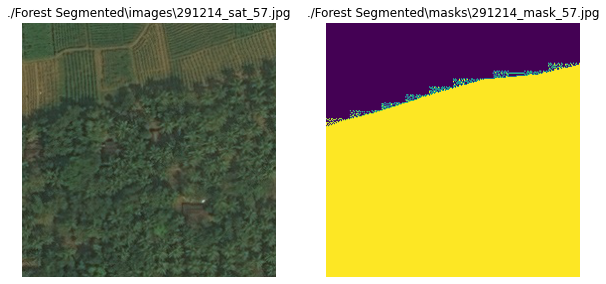

In [15]:
x_t = train_x[100]
y_t = train_y[100]
x =  read_image(x_t)
y =  read_mask(y_t)

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.title(x_t)
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.title(y_t)
plt.imshow(y,vmin=0.0,vmax=1.0)
plt.axis('off')
plt.show()

In [16]:
train_dataset = tf_dataset(train_x,train_y,batch=BATCH_SIZE)
test_dataset = tf_dataset(test_x,test_y,batch=BATCH_SIZE)

#for image,mask in train_dataset:
#    print(image.shape,mask.shape)

### Model

In [17]:

model = build_unet(INPUT_SHAPE)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

callbacks = [
        ModelCheckpoint(MODEL_PATH, monitor="val_loss", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
        CSVLogger(CSV_PATH),
        EarlyStopping(monitor="val_loss", patience=10)
    ]

train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1

    
history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=test_steps,
        callbacks=callbacks
)


Epoch 1/8
511/511 [==============================] - 728s 1s/step - loss: 0.5006 - mean_io_u: 0.1899 - recall: 0.8578 - precision: 0.7888 - val_loss: 0.7442 - val_mean_io_u: 0.1943 - val_recall: 0.4602 - val_precision: 0.8778

Epoch 00001: saving model to unet.h5
Epoch 2/8
511/511 [==============================] - 1083s 2s/step - loss: 0.4590 - mean_io_u: 0.1899 - recall: 0.8717 - precision: 0.8083 - val_loss: 0.4433 - val_mean_io_u: 0.1943 - val_recall: 0.8748 - val_precision: 0.8191

Epoch 00002: saving model to unet.h5
Epoch 3/8
511/511 [==============================] - 917s 2s/step - loss: 0.4492 - mean_io_u: 0.1899 - recall: 0.8792 - precision: 0.8140 - val_loss: 0.4233 - val_mean_io_u: 0.1943 - val_recall: 0.8804 - val_precision: 0.8226

Epoch 00003: saving model to unet.h5
Epoch 4/8
511/511 [==============================] - 910s 2s/step - loss: 0.4434 - mean_io_u: 0.1899 - recall: 0.8727 - precision: 0.8193 - val_loss: 0.4299 - val_mean_io_u: 0.1943 - val_recall: 0.8708 - val

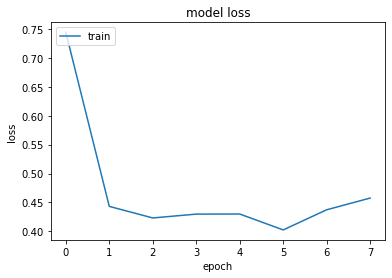

In [19]:
#plt.plot(history.history['acc'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

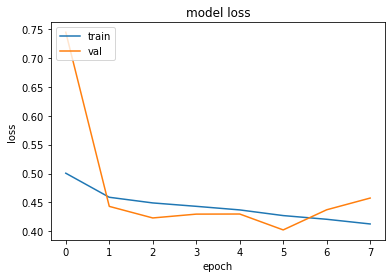

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Prediction

In [21]:
model = tf.keras.models.load_model("unet.h5")

In [22]:
from tqdm import tqdm
test_images =  glob("./test/*")

for path in tqdm(test_images,total=len(test_images)):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    original_image = x
    h, w, _ = x.shape
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    pred_mask = model.predict(x)[0]
    pred_mask = np.concatenate(
        [
            pred_mask,
            pred_mask,
            pred_mask
        ], axis=2)
    #print(pred_mask)
    pred_mask = (pred_mask > 0.5) * 255
    pred_mask = pred_mask.astype(np.float32)
    pred_mask = cv2.resize(pred_mask, (w, h))
    original_image = original_image.astype(np.float32)
    alpha = 0.6
    cv2.addWeighted(pred_mask, alpha, original_image, 1-alpha, 0, original_image)
    name = path.split("\\")[-1]
    #print(f"./output/{name}")
    cv2.imwrite(f"output/{name}", original_image)

0it [00:00, ?it/s]
